In [2]:
import torch
import numpy as np
import pandas as pd
from run_ib import RunIB
from enumerate_lexicons import get_random_lexicon
import enumerate_lexicons as el
import matplotlib.pyplot as plt
import itertools
import math
import einops
from stirling import stirling
import enumerate_lexicons
pd.options.display.max_rows = 250
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.stats import linregress
import scipy
import pickle as pkl

In [ ]:
# def mi_torch(p_xy):
#     """ Calculate mutual information of a distribution P(x,y) 

#     Input: 
#     p_xy: An X x Y array giving p(x,y)
    
#     Output:
#     The mutual information I[X:Y], a nonnegative scalar,
#     """
#     p_x = p_xy.sum(axis=-1, keepdims=True)
#     p_y = p_xy.sum(axis=-2, keepdims=True)
#     return torch.xlogy(p_xy, p_xy).sum() - torch.xlogy(p_x, p_x).sum() - torch.xlogy(p_y, p_y).sum()

# def information_plane_torch(p_x, p_y_x, p_z_x):
#     """ Given p(x), p(y|x), and p(z|x), calculate I[Y:Z] and I[X:Z] """
#     p_xz = torch.mul(p_x[:, None] , p_z_x) # Joint p(x,y), shape X x Y    
#     p_xyz = torch.mul(torch.mul(p_x[:, None, None] , p_y_x[:, :, None]) , p_z_x[:, None, :]) # Joint p(x,y,z), shape X x Y x Z
#     p_yz = p_xyz.sum(axis=0) # Joint p(y,z), shape Y x Z
#     return mi_torch(p_yz), mi_torch(p_xz)

In [ ]:
# logsp = np.logspace(0,2,num = 1500)
# mu = 0.3
# num_dists = 3
# pgs_dists = [0,0.789,-1.315]
# num_words = 3

# gamma = 2

# num_meanings = num_dists * 3
# x = RunIB(mu, gamma, num_dists, pgs_dists)

# p_m = torch.tensor(x.prior) # shape: M
# p_u_m = torch.tensor(x.prob_u_given_m) # shape: M x U

# #initialize encoder q(w|m)
# q_w_m_init = torch.rand(num_meanings, num_words, requires_grad = True) # shape: M x W
# m = torch.nn.Softmax(dim = -1)


# # set up optimizer
# opt = torch.optim.AdamW([q_w_m_init], lr = 2)

# print(m(q_w_m_init))

# for epoch in range(10000):
#     q_w_m = m(q_w_m_init) # normalize such that each row sums up to 1
#     informativity, complexity = information_plane_torch(p_m, p_u_m, q_w_m)
#     loss = complexity - gamma * informativity
#     loss.backward()
#     opt.step()
#     opt.zero_grad()

# m(q_w_m)

In [15]:
# def information_plane(p_x, p_y_x, p_z_x):
#     """ Given p(x), p(y|x), and p(z|x), calculate I[Y:Z] and I[X:Z] """
#     p_xz = p_x[:, None] * p_z_x # Joint p(x,y), shape X x Y    
#     p_xyz = p_x[:, None, None] * p_y_x[:, :, None] * p_z_x[:, None, :] # Joint p(x,y,z), shape X x Y x Z
#     p_yz = p_xyz.sum(axis=0) # Joint p(y,z), shape Y x Z
#     return mi(p_yz), mi(p_xz)

In [34]:
# # now let's try scipy.optimize.basinhopping

# logsp = np.logspace(0,2,num = 1500)
# mu = 0.3
# num_dists = 3
# pgs_dists = [0,0.789,-1.315]
# num_words = 6

# gamma = logsp[200]

# num_meanings = num_dists * 3
# x = RunIB(mu, gamma, num_dists, pgs_dists)

# p_m = x.prior
# p_u_m = x.prob_u_given_m

# def ib_score(q_w_m, p_m, p_u_m, gamma):
#     if q_w_m.ndim == 1:
#         q_w_m = einops.rearrange(q_w_m, '(meaning word) -> meaning word', word = num_words)
#     q_w_m = scipy.special.softmax(q_w_m, axis = -1)
#     informativity, complexity = information_plane(p_m, p_u_m, q_w_m)
#     return complexity - gamma * informativity  

# q_w_m = np.random.rand(num_meanings, num_words)
# func = lambda x: ib_score(x, p_m, p_u_m, gamma)
# minimizer_kwargs = {"method": "BFGS"}

# results = scipy.optimize.basinhopping(func=func, x0=q_w_m, stepsize = 0.5, niter=200, minimizer_kwargs=minimizer_kwargs)

# res = scipy.special.softmax(einops.rearrange(results.x, '(meaning word) -> meaning word', word = num_words), axis = -1)

In [5]:
# method 3: reversed deterministic annealing
DEFAULT_NUM_ITER = 10

def ib(p_x, p_y_x, Z, gamma, num_iter=DEFAULT_NUM_ITER, outer_iter=10, temperature = 1):
    q_z_xs = [_ib(p_x, p_y_x, Z, gamma, num_iter, temperature) for i in range(outer_iter)]
    iplanes = [information_plane(p_x, p_y_x, q) for q in q_z_xs]
    J = np.array([i[1] - gamma * i[0] for i in iplanes])
    return q_z_xs[J.argmin()]

def _ib(p_x, p_y_x, Z, gamma, init, num_iter=DEFAULT_NUM_ITER, temperature = 1):
    """ Find encoder q(Z|X) to minimize J = I[X:Z] - gamma * I[Y:Z].
    
    Input:
    p_x : Distribution on X, of shape X.
    p_y_x : Conditional distribution on Y given X, of shape X x Y.
    gamma : A non-negative scalar value.
    Z : Support size of Z.

    Output: 
    Conditional distribution on Z given X, of shape X x Z.

    """
    # Support size of X
    X = p_x.shape[-1]

    # Support size of Y
    Y = p_y_x.shape[-1]

    # Randomly initialize the conditional distribution q(z|x)
    q_z_x = init #scipy.special.softmax(np.random.randn(X, Z), -1) # shape X x Z
    p_y_x = p_y_x[:, None, :] # shape X x 1 x Y
    p_x = p_x[:, None] # shape X x 1

    # Blahut-Arimoto iteration to find the minimizing q(z|x)
    for _ in range(num_iter):
        q_xz = p_x * q_z_x # Joint distribution q(x,z), shape X x Z
        q_z = q_xz.sum(axis=0, keepdims=True) # Marginal distribution q(z), shape 1 x Z
        q_y_z = ((q_xz / q_z)[:, :, None] * p_y_x).sum(axis=0, keepdims=True) # Conditional decoder distribution q(y|z), shape 1 x Z x Y
        d = ( 
            scipy.special.xlogy(p_y_x, p_y_x)
            - scipy.special.xlogy(p_y_x, q_y_z) # negative KL divergence -D[p(y|x) || q(y|z)]
        ).sum(axis=-1) # expected distortion over Y; shape X x Z
        q_z_x = scipy.special.softmax((np.log(q_z) - gamma*d)/temperature, axis=-1) # Conditional encoder distribution q(z|x) = 1/Z q(z) e^{-gamma*d}

    return q_z_x

def mi(p_xy):
    """ Calculate mutual information of a distribution P(x,y) 

    Input: 
    p_xy: An X x Y array giving p(x,y)
    
    Output:
    The mutual information I[X:Y], a nonnegative scalar,
    """
    p_x = p_xy.sum(axis=-1, keepdims=True)
    p_y = p_xy.sum(axis=-2, keepdims=True)
    return scipy.special.xlogy(p_xy, p_xy).sum() - scipy.special.xlogy(p_x, p_x).sum() - scipy.special.xlogy(p_y, p_y).sum()

def information_plane(p_x, p_y_x, p_z_x):
    """ Given p(x), p(y|x), and p(z|x), calculate I[Y:Z] and I[X:Z] """
    p_xz = p_x[:, None] * p_z_x # Joint p(x,y), shape X x Y    
    p_xyz = p_x[:, None, None] * p_y_x[:, :, None] * p_z_x[:, None, :] # Joint p(x,y,z), shape X x Y x Z
    p_yz = p_xyz.sum(axis=0) # Joint p(y,z), shape Y x Z
    return mi(p_yz), mi(p_xz)

In [19]:
logsp = np.logspace(2,0,num = 1500)
mu = 0.3
num_dists = 3
pgs_dists = [0,0.789,-1.315]
num_words = 9
num_meanings = num_dists * 3

init = np.identity(num_words)

qW_M = []
informativity = []
complexity = []

for gamma in logsp:
    x = RunIB(mu, gamma, num_dists, pgs_dists)
    p_m = x.prior
    p_u_m = x.prob_u_given_m
    q_w_m = _ib(p_m, p_u_m, num_words, gamma, init, num_iter = 20)
    informativity_temp, complexity_temp = information_plane(p_m, p_u_m, q_w_m)
    
    qW_M.append(q_w_m)
    informativity.append(informativity_temp)
    complexity.append(complexity_temp)
    init = q_w_m


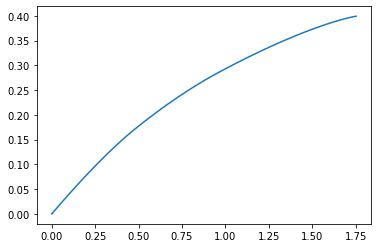

In [22]:
plt.plot(complexity, informativity)